# Setup and imports

In [88]:
import os
import re
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pickle
import heapq
import math

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=13)
matplotlib.rc('axes', titlesize=16)

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

business_mails_path = "./drive/My Drive/Predictive keyboard/data/Business Corpus/enron_mail_20150507.tar.gz"
user_mails_path = './drive/My Drive/Predictive keyboard/data/User/Sent.mbox'
business_corpus_file_location = "./drive/My Drive/Predictive keyboard/data/Business Corpus/business_corpus.txt"
user_corpus_file_location = "./drive/My Drive/Predictive keyboard/data/User/user_corpus.txt"
business_model_save_location = "./drive/My Drive/Predictive keyboard/model/Business/business_keras_model.h5"
business_model_history_location = "./drive/My Drive/Predictive keyboard/model/Business/business_keras_model_history.p"
user_model_save_location = "./drive/My Drive/Predictive keyboard/model/User/user_keras_model.h5"
user_model_history_location = "./drive/My Drive/Predictive keyboard/model/User/user_keras_model_history.p"

# !tar -xf ./drive/My\ Drive/Predictive\ keyboard/data/Business\ Corpus/enron_mail_20150507.tar.gz -C ./drive/My\ Drive/Predictive\ keyboard/data/Business\ Corpus/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read data

## Business corpus

### Extract files

In [0]:
business_mails_console_path = re.sub(' ', '\ ', business_mails_path)

!mkdir ./business_mails
!tar -xf $business_mails_console_path -C ./business_mails/

business_mails_extracted_path = "./business_mails/maildir/"

### Read files

In [4]:
startings = ['X-FileName:']

endings = ['---', 'regards', 'cordially', '@', 'from:']

date_pattern = re.compile(r'\d+/\d+/\d+ \d+:\d+')
mails_count = 0
all_messages = []

people = sorted(os.listdir(business_mails_extracted_path))
people = [person for person in people if not person.startswith('.')]

for person in people:
  mailboxes = sorted(os.listdir(os.path.join(business_mails_extracted_path, person)))
  sent_mailboxes = [mailbox for mailbox in mailboxes if 'sent' in mailbox]
  for sent_mailbox in sent_mailboxes:
    mails = sorted(os.listdir(os.path.join(business_mails_extracted_path, person, sent_mailbox)))
    for mail_file in mails:
      mail = os.path.join(business_mails_extracted_path, person, sent_mailbox, mail_file)
      if os.path.isfile(mail):
        f = open(mail)
        mail_start = 0
        message = []
        try:
          for line in f:
            line = re.sub("=\n", "", line)
            if any(starting in line for starting in startings):
              mail_start = 1
            elif any(ending in line.lower() for ending in endings) or bool(date_pattern.search(line)):
              mail_start = 0
              complete_message = ''.join(message).strip()
            elif mail_start == 1:
              message.append(line)
            else:
              continue
        except:
          continue
        if len(complete_message) > 0:
          mails_count+=1
          all_messages.append(complete_message)

print(mails_count, ' business mails read')

65631  business mails read


### Create corpus

In [0]:
business_corpus = []
for message in all_messages:
  for line in message.split('\n'):
    if len(line) > 10:
      business_corpus.append(line.lower())

### Write corpus to file

In [0]:
with open(business_corpus_file_location, 'w') as f:
  for item in business_corpus:
    f.write("%s\n" % item)

## User emails corpus

### Read mails

In [6]:
endings = ('https://www.linkedin.com/in/skand-upmanyu/', 'skand upmanyu', 'thanks and regards,', '---------- forwarded message ---------', 'pfa', 'on mon,', 'on tue,', 'on wed,', 'on thu,', 'on fri,', 'on sat,', 'on sun,', '--00')

f = open(user_mails_path)
mails_count = 0
mail_start = 0
body_start = 0
user_corpus = []
message = []
for line in f:
  line = re.sub("\n", "", line)
  if line == 'From: Skand Upmanyu <su2236@columbia.edu>':
    mail_start = 1
  elif (mail_start == 1) & (line == 'Content-Type: text/plain; charset="UTF-8"'):
    body_start = 1
  elif (mail_start == 1) & (body_start == 1) & (line.lower().startswith(endings)):
    mail_start = 0
    body_start = 0
    complete_message = ' '.join(message).strip()
    message = []
    if len(complete_message) > 0:
      mails_count+=1
      user_corpus.append(complete_message.lower())
  elif (mail_start == 1) & (body_start == 1) & (not(line.startswith('Content-')) ):
    message.append(line)
  else:
    continue

print(mails_count, ' user mails read')

516  user mails read


### Write corpus to file

In [0]:
with open(user_corpus_file_location, 'w') as f:
  for item in user_corpus:
    f.write("%s\n" % item)

# Load data

## Business corpus

In [0]:
business_corpus = []
with open(business_corpus_file_location, 'r') as f:
  for line in f:
    business_corpus.append(line.strip())

## User mails corpus

In [0]:
user_corpus = []
with open(user_corpus_file_location, 'r') as f:
  for line in f:
    user_corpus.append(line.strip())

## Analysis

In [91]:
business_words = []
for line in business_corpus:
  business_words.extend(line.split(" "))

user_words = []
for line in user_corpus:
  user_words.extend(line.split(" "))

print('No. of words in Business Corpus: ', len(business_words))
print('No. of unique words in Business Corpus: ', len(set(business_words)))
print('No. of characters in Business Corpus: ', len(' '.join(business_corpus)))
print('No. of unique characters in Business Corpus: ', len(set(' '.join(business_corpus))))

print('No. of words in User Corpus: ', len(user_words))
print('No. of unique words in User Corpus: ', len(set(user_words)))
print('No. of characters in Business Corpus: ', len(' '.join(user_corpus)))
print('No. of unique characters in Business Corpus: ', len(set(' '.join(user_corpus))))

No. of words in Business Corpus:  2172779
No. of unique words in Business Corpus:  84361
No. of characters in Business Corpus:  11583356
No. of unique characters in Business Corpus:  68
No. of words in User Corpus:  29870
No. of unique words in User Corpus:  4472
No. of characters in Business Corpus:  164941
No. of unique characters in Business Corpus:  67



# Data preparation

## Unique characters

In [92]:
chars = sorted(list(set(' '.join(business_corpus) +  ' '.join(user_corpus))))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'No. of unique characters in corpus: {len(chars)}')

No. of unique characters in corpus: 70


## Prepare sequences

### Configurations

In [0]:
SEQUENCE_LENGTH = 100
step = 1
min_length = 10

### Function

In [0]:
def prepare_sequences(corpus, SEQUENCE_LENGTH=SEQUENCE_LENGTH, step=step, min_length=min_length):
  sentences = []
  next_chars = []
  for line in corpus:
    for i in range(1, len(line), step):
      sentence = line[:i]
      if len(sentence) >= min_length:
        if len(sentence) < SEQUENCE_LENGTH:
          sentence = " "*(SEQUENCE_LENGTH - len(sentence)) + sentence
        if len(sentence) > SEQUENCE_LENGTH:
          sentence = sentence[-SEQUENCE_LENGTH:]
        next_char = line[i]
        sentences.append(sentence)
        next_chars.append(next_char)
      else:
        continue
  print(f'Total number of training examples: {len(sentences)}')

  return sentences, next_chars

### Business data

In [95]:
business_sentences, business_next_chars = prepare_sequences(business_corpus, SEQUENCE_LENGTH=SEQUENCE_LENGTH, step=step, min_length=min_length)

Total number of training examples: 9564053


### User data

In [96]:
user_sentences, user_next_chars = prepare_sequences(user_corpus, SEQUENCE_LENGTH=SEQUENCE_LENGTH, step=step, min_length=min_length)

Total number of training examples: 159275


## Train validation split

### Function

In [0]:
def train_val_test_split(sentences, next_chars, val_perc = 0.05, test_perc = 0.05):
  data = list(zip(sentences, next_chars))
  random.seed(4)
  random.shuffle(data)
  sentences_s, next_chars_s = zip(*data)
  train_sentences = sentences_s[:int((1 - (val_perc + test_perc))*len(sentences_s))]
  train_next_chars = next_chars_s[:int((1 - (val_perc + test_perc))*len(sentences_s))]
  val_sentences = sentences_s[int((1 - (val_perc + test_perc))*len(sentences_s)): int((1 - (test_perc))*len(sentences_s))]
  val_next_chars = next_chars_s[int((1 - (val_perc + test_perc))*len(sentences_s)): int((1 - (test_perc))*len(sentences_s))]
  test_sentences = sentences_s[int((1 - (test_perc))*len(sentences_s)):]
  test_next_chars = next_chars_s[int((1 - (test_perc))*len(sentences_s)):]
  return train_sentences, train_next_chars, val_sentences, val_next_chars, test_sentences, test_next_chars

### Business data

In [98]:
business_train_sentences, business_train_next_chars, \
business_val_sentences, business_val_next_chars, \
business_test_sentences, business_test_next_chars = train_val_test_split(business_sentences, business_next_chars, val_perc = 0.05, test_perc = 0.05)

print("Training observations (business): ", len(business_train_sentences))
print("Validation observations (business): ", len(business_val_sentences))
print("Test observations (business): ", len(business_test_sentences))

Training observations (business):  8607647
Validation observations (business):  478203
Test observations (business):  478203


### User data

In [99]:
user_train_sentences, user_train_next_chars, \
user_val_sentences, user_val_next_chars, \
user_test_sentences, user_test_next_chars, = train_val_test_split(user_sentences, user_next_chars, val_perc = 0.05, test_perc = 0.05)

print("Training observations (user): ", len(user_train_sentences))
print("Validation observations (user): ", len(user_val_sentences))
print("Test observations (user): ", len(user_test_sentences))

Training observations (user):  143347
Validation observations (user):  7964
Test observations (user):  7964


## Prepare tensor data

### Function

In [0]:
def prep_tensor_data(sentences, next_chars, chars=chars, SEQUENCE_LENGTH=SEQUENCE_LENGTH):
  X = np.zeros((len(sentences), SEQUENCE_LENGTH))
  y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
  for i, sentence in enumerate(sentences):
    for j, char in enumerate(sentence):
      X[i, j] = char_indices[char]
    y[i, char_indices[next_chars[i]]] = 1
  return X, y

### Generator

In [0]:
def generator(train_sentences, train_next_chars, batch_size):

  samples_per_epoch = len(train_sentences)
  number_of_batches = samples_per_epoch/batch_size
  counter = 0

  while True:

    X_batch, y_batch = prep_tensor_data(train_sentences[batch_size*counter : batch_size*(counter+1)], train_next_chars[batch_size*counter : batch_size*(counter+1)])
    counter += 1
    yield X_batch, y_batch

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

# Learning from business mails

## Define model

In [25]:
input_ = tf.keras.Input(shape=(SEQUENCE_LENGTH), name='Input_layer')
embeddings = layers.Embedding(input_dim=len(chars), output_dim=64, input_length=SEQUENCE_LENGTH, name="Embedding_layer")(input_)

x1 = layers.Conv1D(filters=50, kernel_size=5, strides=1, padding='valid', name="1D_Convolution_layer_1")(embeddings)
x1 = layers.BatchNormalization(name="Batch_normalization_1")(x1)
x1 = layers.GRU(units=128, return_sequences=True, name="GRU_1")(x1)
x1 = layers.BatchNormalization(name="Batch_normalization_4")(x1)
out1 = layers.GRU(units=64, name="GRU_4")(x1)

x2 = layers.Conv1D(filters=50, kernel_size=5, strides=1, padding='valid', name="1D_Convolution_layer_2")(embeddings)
x2 = layers.BatchNormalization(name="Batch_normalization_2")(x2)
x2 = layers.GRU(units=128, return_sequences=True, name="GRU_2")(x2)
x2 = layers.BatchNormalization(name="Batch_normalization_5")(x2)
out2 = layers.GRU(units=64, name="GRU_5")(x2)

x3 = layers.Conv1D(filters=50, kernel_size=5, strides=1, padding='valid', name="1D_Convolution_layer_3")(embeddings)
x3 = layers.BatchNormalization(name="Batch_normalization_3")(x3)
x3 = layers.GRU(units=128, return_sequences=True, name="GRU_3")(x3)
x3 = layers.BatchNormalization(name="Batch_normalization_6")(x3)
out3 = layers.GRU(units=64, name="GRU_6")(x3)

out = layers.Concatenate(name="Concatenate_layer")([out1, out2, out3])
out = layers.BatchNormalization(name="Batch_normalization_7")(out)
out = layers.Dense(len(chars), activation = "softmax", name="Dense_layer")(out)

model = tf.keras.Model(inputs=input_, outputs=out)

optimizer = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.categorical_crossentropy
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
Embedding_layer (Embedding)     (None, 100, 64)      4480        Input_layer[0][0]                
__________________________________________________________________________________________________
1D_Convolution_layer_1 (Conv1D) (None, 96, 50)       16050       Embedding_layer[0][0]            
__________________________________________________________________________________________________
1D_Convolution_layer_2 (Conv1D) (None, 96, 50)       16050       Embedding_layer[0][0]            
____________________________________________________________________________________________

## Train model

In [0]:
batch_size = 128
business_model_history = model.fit(generator(business_train_sentences, business_train_next_chars, batch_size), validation_data=generator(business_val_sentences, business_val_next_chars, batch_size), steps_per_epoch = math.floor(len(business_train_sentences)/batch_size), validation_steps = math.floor(len(business_val_sentences)/batch_size), epochs = 10).history

Epoch 1/10
67247/67247 [==============================] - 3155s 47ms/step - loss: 1.3706 - accuracy: 0.5998 - val_loss: 1.2509 - val_accuracy: 0.6291
Epoch 2/10
67247/67247 [==============================] - 3170s 47ms/step - loss: 1.2314 - accuracy: 0.6341 - val_loss: 1.2071 - val_accuracy: 0.6402
Epoch 3/10
67247/67247 [==============================] - 3174s 47ms/step - loss: 1.1968 - accuracy: 0.6431 - val_loss: 1.1876 - val_accuracy: 0.6459
Epoch 4/10
67247/67247 [==============================] - 3149s 47ms/step - loss: 1.1770 - accuracy: 0.6483 - val_loss: 1.1748 - val_accuracy: 0.6495
Epoch 5/10
67247/67247 [==============================] - 3133s 47ms/step - loss: 1.1637 - accuracy: 0.6517 - val_loss: 1.1662 - val_accuracy: 0.6516
Epoch 6/10
67247/67247 [==============================] - 3125s 46ms/step - loss: 1.1539 - accuracy: 0.6542 - val_loss: 1.1609 - val_accuracy: 0.6533
Epoch 7/10
67247/67247 [==============================] - 3133s 47ms/step - loss: 1.1465 - accuracy:

## Save model

In [0]:
model.save(business_model_save_location)
pickle.dump(business_model_history, open(business_model_history_location, "wb"))

## Load model

In [0]:
model = tf.keras.models.load_model(business_model_save_location)
business_model_history = pickle.load(open(business_model_history_location, "rb"))

## Plot accuracy

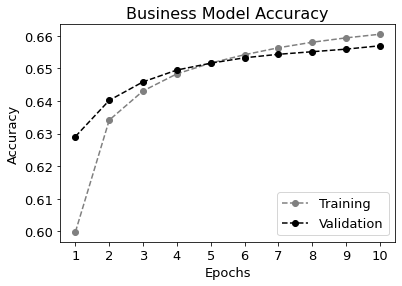

In [43]:
plt.plot(np.arange(1,11), business_model_history['accuracy'], linestyle='--', marker='o', color='grey')
plt.plot(np.arange(1,11), business_model_history['val_accuracy'], linestyle='--', marker='o', color='black')
plt.xticks(np.arange(1,11))
plt.title('Business Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right');

## Plot loss

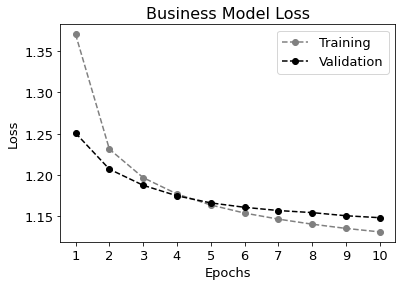

In [44]:
plt.plot(np.arange(1,11), business_model_history['loss'], linestyle='--', marker='o', color='grey')
plt.plot(np.arange(1,11), business_model_history['val_loss'], linestyle='--', marker='o', color='black')
plt.xticks(np.arange(1,11))
plt.title('Business Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='top right');

## Test performance

In [37]:
batch_size = 128
business_test_loss, business_test_accuracy = model.evaluate(generator(business_test_sentences, business_test_next_chars, batch_size), steps = math.floor(len(business_test_sentences)/batch_size))
print("Test loss on business model: ", business_test_loss)
print("Test accuracy on business model: ", business_test_accuracy)

3735/3735 [==============================] - 65s 17ms/step - loss: 1.1482 - accuracy: 0.6572
Test loss on business model:  1.1481597423553467
Test accuracy on business model:  0.6572142839431763


# Predictions

## Helper functions

### Pad and create tensor

In [0]:
def prepare_input(text):
  if len(text) < SEQUENCE_LENGTH:
    text = ' '*(SEQUENCE_LENGTH - len(text)) + text
  elif len(text) > SEQUENCE_LENGTH:
    text = text[-SEQUENCE_LENGTH:]
  x = np.zeros((1, SEQUENCE_LENGTH))
  for j, char in enumerate(text):
      x[0, j] = char_indices[char]
  
  return x

### Top 5 predictions

In [0]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

### Predict till word completion

In [0]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

## Main function

In [0]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

## Input text

In [0]:
text = ["Can you let ",
        "Can you let me ",
        "Can you let me know ",
        "Can you let me know if ",
        "Can you let me know if you ",
        "Can you let me know if you have ",
        "Can you let me know if you have compl",
        "Can you let me know if you have completed ",
        "Can you let me know if you have completed the ",
        "Can you let me know if you have completed the proj",
        "Can you let me know if you have completed the project ",
        "Can you let me know if you have completed the project that ",
        "Can you let me know if you have completed the project that we ",
        "Can you let me know if you have completed the project that we disc"]

## Predict

In [83]:
for q in text:
    seq = q.lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

can you let 
['me ', 'him ', 'you ', 'them ', 'change ']

can you let me 
['know ', 'see ', 'have ', 'the ', 'check ']

can you let me know 
['if ', 'what ', 'how ', 'and ', 'that ']

can you let me know if 
['you ', 'this ', 'i ', 'any ', 'we ']

can you let me know if you 
['have ', 'need ', 'want ', 'can ', 'are ']

can you let me know if you have 
['any ', 'questions ', 'some ', 'to ', 'not ']

can you let me know if you have compl
['eted ', 'icated ', 'y ', 'ained ', 'oyed ']

can you let me know if you have completed 
['the ', 'and ', 'in ', 'on ', 'by ']

can you let me know if you have completed the 
['contract ', 'process ', 'state ', 'following ', 'deal ']

can you let me know if you have completed the proj
['ect ', 'ust ', 'ose ', 'icing ', 'dc ']

can you let me know if you have completed the project 
['for ', 'in ', 'when ', 'and ', 'contract ']

can you let me know if you have completed the project that 
['we ', 'the ', 'i ', 'you ', 'he ']

can you let me know if you hav

# Personalization using user mails

In [49]:
batch_size = 128
user_model_history = model.fit(generator(user_train_sentences, user_train_next_chars, batch_size), validation_data=generator(user_val_sentences, user_val_next_chars, batch_size), steps_per_epoch = math.floor(len(user_train_sentences)/batch_size), validation_steps = math.floor(len(user_val_sentences)/batch_size), epochs = 5).history

Epoch 1/5
1119/1119 [==============================] - 55s 49ms/step - loss: 1.2173 - accuracy: 0.6585 - val_loss: 1.1338 - val_accuracy: 0.6779
Epoch 2/5
1119/1119 [==============================] - 53s 48ms/step - loss: 1.0240 - accuracy: 0.7066 - val_loss: 1.0849 - val_accuracy: 0.6923
Epoch 3/5
1119/1119 [==============================] - 53s 48ms/step - loss: 0.9235 - accuracy: 0.7339 - val_loss: 1.0655 - val_accuracy: 0.6986
Epoch 4/5
1119/1119 [==============================] - 53s 48ms/step - loss: 0.8425 - accuracy: 0.7556 - val_loss: 1.0616 - val_accuracy: 0.7056
Epoch 5/5
1119/1119 [==============================] - 54s 48ms/step - loss: 0.7724 - accuracy: 0.7751 - val_loss: 1.0697 - val_accuracy: 0.7099


## Save model

In [0]:
model.save(user_model_save_location)
pickle.dump(user_model_history, open(user_model_history_location, "wb"))

## Load model

In [0]:
model = tf.keras.models.load_model(user_model_save_location)
user_model_history = pickle.load(open(user_model_history_location, "rb"))

## Plot accuracy

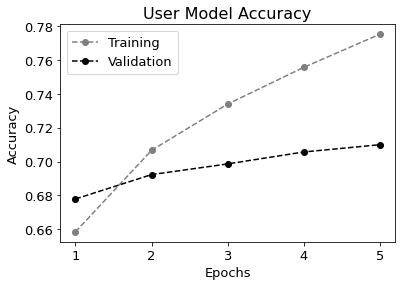

In [84]:
plt.plot(np.arange(1,6), user_model_history['accuracy'], linestyle='--', marker='o', color='grey')
plt.plot(np.arange(1,6), user_model_history['val_accuracy'], linestyle='--', marker='o', color='black')
plt.xticks(np.arange(1,6))
plt.title('User Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left');

## Plot loss

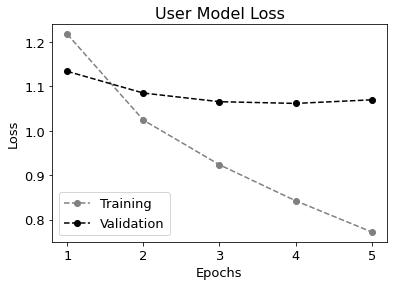

In [85]:
plt.plot(np.arange(1,6), user_model_history['loss'], linestyle='--', marker='o', color='grey')
plt.plot(np.arange(1,6), user_model_history['val_loss'], linestyle='--', marker='o', color='black')
plt.xticks(np.arange(1,6))
plt.title('User Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower left');

## Test performance

In [102]:
batch_size = 128
user_test_loss, user_test_accuracy = model.evaluate(generator(user_test_sentences, user_test_next_chars, batch_size),
                                                    steps = math.floor(len(user_test_sentences)/batch_size))
print("Test loss on user model: ", user_test_loss)
print("Test accuracy on user model: ", user_test_accuracy)

62/62 [==============================] - 21s 340ms/step - loss: 1.0574 - accuracy: 0.7064
Test loss on user model:  1.0574055910110474
Test accuracy on user model:  0.7064012289047241


# Customized predictions

In [0]:
text = [
"Hi Prof",
"Hi Professor, ",
"Hi Professor, hope you ",
"Hi Professor, hope you are ",
"Hi Professor, hope you are doing ",
"Hi Professor, hope you are doing well.",
"Hi Professor, hope you are doing well. I wanted to thank ",
"Hi Professor, hope you are doing well. I wanted to thank you ",
"Hi Professor, hope you are doing well. I wanted to thank you for ",
"Hi Professor, hope you are doing well. I wanted to thank you for taking ",
"Hi Professor, hope you are doing well. I wanted to thank you for taking the ",
"Hi Professor, hope you are doing well. I wanted to thank you for taking the time ",
"Hi Professor, hope you are doing well. I wanted to thank you for taking the time for ",
"Hi Professor, hope you are doing well. I wanted to thank you for taking the time for the ",
"Hi Professor, hope you are doing well. I wanted to thank you for taking the time for the mee",
"Hi Professor, hope you are doing well. I wanted to thank you for taking the time for the meeting ",
"Hi Professor, hope you are doing well. I wanted to thank you for taking the time for the meeting yeste"
]

In [151]:
for q in text:
    seq = q.lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

hi prof
['essor, ', 'it, ', '. ', ' to ', 'ord ']

hi professor, 
[' i ', 'i ', 'and ', 'we ', 'so ']

hi professor, hope you 
['are ', 'had ', 'want ', 'can ', 'got ']

hi professor, hope you are 
['doing ', 'going ', 'already ', 'really ', 'still ']

hi professor, hope you are doing 
['well. ', 'a ', 'the ', 'forward ', 'great ']

hi professor, hope you are doing well.
['  ', '..i ', 'come ', 'upmention ', ', ']

hi professor, hope you are doing well. i wanted to thank 
['you ', 'to ', 'some ', 'please ', 'very ']

hi professor, hope you are doing well. i wanted to thank you 
['for ', 'then ', 'so ', 'and ', 'might ']

hi professor, hope you are doing well. i wanted to thank you for 
['taking ', 'your ', 'catch ', 'reaching ', 'sure ']

hi professor, hope you are doing well. i wanted to thank you for taking 
['the ', 'my ', 'some ', 'it ', 'a ']

hi professor, hope you are doing well. i wanted to thank you for taking the 
['time ', 'mean ', 'projects ', 'distance ', 'students ']

hi 